In [91]:
import random
import socket
import struct
import numpy as np
import copy
import hashlib
import matplotlib.pylab as plt
import intervals
from pprint import pprint
import pandas as pd
import sys
from scipy.stats.kde import gaussian_kde
import scipy.stats as stats
from numpy import linspace
import math

In [92]:
#Defining Parameters
numberOfBitsOfHash = 160 #As SHA-1
# numberOfBitsOfHash=4
numberOfNodes=1000
numberOfDataPoints=10000
numberOfSearchQueries=1000000
addHops={}
nodeListDictionary={}
masterNode={}
# if len(sys.argv)>1:
#     if sys.argv[1]=="--log-enable":
#         logEnabled=1
#     elif sys.argv[1]=="--help":
#         print("To execute Code : python ChordFinal.py")
#         print("To enable logs: python ChordFinal.py --log-enable")
#         exit(0)
#     else:
#         print("Invalid Option")
#         exit(0)
# else:
#     logEnabled=0
    
path=""

In [93]:
#Generic Functions
def contains(key1,lowerBound,upperBound,numberOfBitsOfHash,flag):
    if lowerBound==upperBound and flag==2 and key1==lowerBound:
        return 0
    elif lowerBound==upperBound:
        return 1
    if(flag==1): #Closed Interval
        if key1==lowerBound or key1==upperBound:
            return 1
    elif(flag==2): #Open Interval
        if key1==lowerBound or key1==upperBound:
            return 0
    elif(flag==3): #open closed interval
        if key1==lowerBound:
            return 0
        elif key1==upperBound:
            return 1
    elif(flag==4): #closed open interval
        if key1==lowerBound:
            return 1
        elif key1==upperBound:
            return 0
    

    if lowerBound<upperBound:
        diff = upperBound - lowerBound
        temp1 = key1 - lowerBound
        temp2 = upperBound-key1
        if temp1<diff and temp2<diff:
            return 1
        else:
            return 0
    elif lowerBound>upperBound:
        temp=lowerBound
        lowerBound=upperBound
        upperBound=temp
        diff = upperBound - lowerBound
        temp1 = key1 - lowerBound
        temp2 = upperBound-key1
        if temp1<diff and temp2<diff:
            return 0
        else:
            return 1
        
def initializeFingerTableOfFirstNode(firstNode):
    start_list=[]
    interval_list=[]
    successorList=[]
    for k in range(1,numberOfBitsOfHash+1):
        start=(firstNode.nodeId+pow(2,k-1))%(pow(2,numberOfBitsOfHash))
        end=(firstNode.nodeId+pow(2,k)-1)%(pow(2,numberOfBitsOfHash))
        start_list.append(start)
        successorList.append(firstNode)    
    fingerTable = np.rec.fromarrays((start_list,successorList ), names=('start','node'))  

    return fingerTable

def createChordRing(firstNode):
    firstNode.successor=firstNode
    firstNode.fingerTable=initializeFingerTableOfFirstNode(firstNode)
    firstNode.predecessor = firstNode
    return firstNode


def initializeNewNode(newNodeId):
    newNode = Node(newNodeId)
    newNode.successor = masterNode.findSuccessor(newNode.nodeId)
#     newNode.successor = firstNode.findSuccessor(newNode.nodeId)
    newNode.fingerTable = initializeFingerTableOfFirstNode(newNode)
    return newNode

def printFingerTable(node):
    start=[]
    nodelist=[]
    for i in node.fingerTable:
        start.append(i[0])
        nodelist.append(i[1].nodeId)
    df = pd.DataFrame({"Start":start,"Node":nodelist})
    print(df.to_string(index=False))
    
def printAllNodes():
    nodeListDictionary1={}
    nodeListDictionary1={masterNode.nodeId:nodeListDictionary[masterNode.nodeId]}
    for i in sorted(list(nodeListDictionary1.keys())):
        print(" Node - ",i)
        print(" Successor - ",nodeListDictionary1[i].successor.nodeId)
        print(" Predecessor - ",nodeListDictionary1[i].predecessor.nodeId)
        printFingerTable(nodeListDictionary1[i])
        print("--------------------------------")
     

def addFirstTwoNodes(firstNode,secondNode):
    for index,i in enumerate(firstNode.fingerTable):
        if contains(i.start,firstNode.nodeId,secondNode.nodeId,numberOfBitsOfHash,1):
            firstNode.fingerTable[index].node=secondNode

    for index,i in enumerate(secondNode.fingerTable):
        if contains(i.start,secondNode.nodeId,firstNode.nodeId,numberOfBitsOfHash,1):
            secondNode.fingerTable[index].node=firstNode
    
    firstNode.successor=secondNode
    firstNode.predecessor=secondNode
    secondNode.successor=firstNode
    secondNode.predecessor=firstNode
    return (firstNode,secondNode)



#Storing 10000 dataPoints
def storingDataPoints():
    dataStoredTemp=random.sample(range(10, 1000000), 10000)
    for index,i in enumerate(dataStoredTemp):
        data = str(i)
        keyData = int(hashlib.sha1(data.encode('utf-8')).hexdigest(),16)
        masterNode.addData(keyData,data)
    return dataStoredTemp

In [94]:
class Node:
    def __init__(self, nodeId):
        self.nodeId = nodeId
        self.fingerTable = None
        self.predecessor=None
#         self.successor=[nodeId]
        self.successor=None
        self.data={}
    
    #Find Successor
    def findClosestPreceedingFinger(self,id):
        for i in range(numberOfBitsOfHash-1,-1,-1):
            if(contains(self.fingerTable[i].node.nodeId,self.nodeId,id,numberOfBitsOfHash,2)):
                return self.fingerTable[i].node
        return self   
    
    def findPredecessor(self,id):
        idCopy=self
        jumps=0
        global path
        while (not contains(id,idCopy.nodeId,idCopy.successor.nodeId,numberOfBitsOfHash,3)):
            path+=str(idCopy.nodeId)+"->"
            jumps+=1
            idCopy=idCopy.findClosestPreceedingFinger(id)
        global addHops
        addHops[id]=jumps
        return idCopy
    
    def findSuccessor(self,id):
        predecessor = self.findPredecessor(id)
        return predecessor.successor
    
    #Joining a node
    def updateFingerTable(self,node,i):
        if contains(node.nodeId,self.nodeId,self.fingerTable[i].node.nodeId,numberOfBitsOfHash,4):
            self.fingerTable[i].node = node
            p = self.predecessor
            if p.nodeId!=node.nodeId:
                p.updateFingerTable(node,i)

    def updateOthers(self):
        for i in range(1,numberOfBitsOfHash+1):
            pred = self.findSuccessor((self.nodeId - pow(2,i-1))%pow(2,numberOfBitsOfHash))
            if not pred.nodeId==(self.nodeId - pow(2,i-1))%pow(2,numberOfBitsOfHash):
                pred = self.findPredecessor((self.nodeId - pow(2,i-1))%pow(2,numberOfBitsOfHash))
            if pred.nodeId==self.nodeId:
                continue
            pred.updateFingerTable(self,i-1)

    def initFingerTable(self,existingNode):
        self.fingerTable[0].node = existingNode.findSuccessor(self.fingerTable[0].start)
        self.successor = self.fingerTable[0].node
        self.predecessor = self.successor.predecessor
        self.successor.predecessor = self
        self.predecessor.successor = self
        self.predecessor.fingerTable[0].node = self
        for i in range(0,numberOfBitsOfHash-1):
            if contains(self.fingerTable[i+1].start,self.nodeId,self.fingerTable[i].node.nodeId,numberOfBitsOfHash,4):
                self.fingerTable[i+1].node = self.fingerTable[i].node
            else:
                self.fingerTable[i+1].node = existingNode.findSuccessor(self.fingerTable[i+1].start)

    def transferKeys(self,successor):
        updated_keys = []
        for key,value in successor.data.items():
            if int(key)<=int(self.nodeId):
                self.data[key]=value
                updated_keys.append(key)
            else:
                continue
        for i in updated_keys:
            del successor.data[i]
                
    def join(self,existingNode):
        self.initFingerTable(existingNode)
        self.updateOthers()
        self.transferKeys(self.successor)

    
    #Node Failure
    def updateFingerTableOnFailure(self,node,i):
        if(node.nodeId==self.fingerTable[i].node.nodeId):
            self.fingerTable[i].node=node.successor
            p = self.predecessor
            p.updateFingerTableOnFailure(node,i)

    def updateOthersOnFailure(self):
        for i in range(1,numberOfBitsOfHash+1):
            pred = self.findSuccessor((self.nodeId - pow(2,i-1))%pow(2,numberOfBitsOfHash))
            if not pred.nodeId==(self.nodeId - pow(2,i-1))%pow(2,numberOfBitsOfHash):
                pred = self.findPredecessor((self.nodeId - pow(2,i-1))%pow(2,numberOfBitsOfHash))
            pred.updateFingerTableOnFailure(self,i-1)
            
    def transferDataToSuccessor(self):
        succ = self.successor
        succ.data.update(self.data)
        
    def nodeFailure(self):
        self.transferDataToSuccessor()
        self.updateOthersOnFailure()
        self.predecessor.successor=self.successor
        self.successor.predecessor=self.predecessor

    
    #Stabilization of Network
    def notify(self,origNode):
        if self.predecessor or contains(origNode.nodeId,self.predecessor.nodeId,self.nodeId,numberOfBitsOfHash,2):
            self.predecessor=origNode
            
    def stabilize(self):
        x = self.successor.predecessor
        if contains(x.nodeId,self.nodeId,self.successor.nodeId,numberOfBitsOfHash,2):
            self.successor=x
        self.successor.notify(self)
    
    def fixFingerTables(self):
        for i in range(0,numberOfBitsOfHash):
            self.fingerTable[i].node = self.findSuccessor(self.fingerTable[i].start)    
        return self
   
    #Adding data to a node
    def addData(self,key,value):
        nodeOfData = self.findSuccessor(key)
        if key not in nodeOfData.data.keys():
            nodeOfData.data[key]=[]
            nodeOfData.data[key].append(value)
        else:
            nodeOfData.data[key].append(value)
            
    #Lookup Query
    def lookup(self,key):
        requiredNode = self.findSuccessor(key)
        if key in requiredNode.data.keys():
            return requiredNode
        return None
    

In [96]:
fp = open("logFile.log","w")
totalData={}
totalDataAfterDeletion={}
numNodes = [100,500,1000]
back1 = {}
for numnodes in numNodes:
    back1 = nodeListDictionary
    nodeListDictionary={}
    #Generate IP Addresses
    print("------------------Number of Nodes : ",numnodes,"---------------------")
    numberOfNodes=numnodes
    totalData[numnodes]=[]
    print("--------------Generating IP Addresses-------------------")
    all_ip_address=[]
    dataStored=[]
    for i in range(0,numberOfNodes):
        temp = socket.inet_ntoa(struct.pack('>I', random.randint(0x3cffffff, 0xffffffff)))
        if(temp not in all_ip_address):
            all_ip_address.append(temp)
        else:
            i-=1

    print("-------------Calculating SHA-1 hash of all IP Addresses-----------------")
    #Calculating SHA-1 (160 bit) hash of IP Address of a node
    hashSet = {}
    for ip in all_ip_address:
        hashSet[ip]=int(hashlib.sha1(ip.encode('utf-8')).hexdigest(),16)

    sortedHashSet = {k: v for k, v in sorted(hashSet.items(), key=lambda item: item[1])}
    sortedKeys = list(sortedHashSet.keys())

    masterNode = Node(sortedHashSet[sortedKeys[0]])
    masterNode = createChordRing(masterNode)
    secondNode=initializeNewNode(sortedHashSet[sortedKeys[1]])
    (masterNode,secondNode)=addFirstTwoNodes(masterNode,secondNode)
    nodeListDictionary={}
    nodeListDictionary[sortedHashSet[sortedKeys[0]]]=masterNode
    nodeListDictionary[sortedHashSet[sortedKeys[1]]]=secondNode

    print("----------------Adding Nodes to the Chord Network----------------")
    for i in range(2,numberOfNodes):
        print(i)
        path=""
        tempNode = initializeNewNode(sortedHashSet[sortedKeys[i]])
        tempNode.join(masterNode)
        fp.write(str(tempNode.nodeId)+" Path:" +path+"\n")
        nodeListDictionary[sortedHashSet[sortedKeys[i]]]=tempNode

    #Fixing Finger Tables
    for key,value in nodeListDictionary.items():
        nodeListDictionary[key]=value.fixFingerTables()

    #Storing Data
    print("-----------------Storing Data-----------------------------")
    dataStored=storingDataPoints()

    dataToSearch = random.sample(range(1, 1060000), numberOfSearchQueries)

    print("-----------------Search Begins----------------------------")

    hopData = {}
    flag = 0
    for i in dataToSearch:
#         print("Required Data ",i)
        if flag%1000==0:
            print("Data Searched: ",flag)
        hashValueOfData = int(hashlib.sha1(str(i).encode('utf-8')).hexdigest(),16)
        addHops[hashValueOfData]=0
        result = masterNode.lookup(hashValueOfData)
        hopData[hashValueOfData]=addHops[hashValueOfData]
        flag+=1
    
    totalData[numnodes].append(hopData)
    print("-----------Deleting 50% nodes------------------")
    allKeys = list(nodeListDictionary.keys())
    allKeys.remove(masterNode.nodeId)
    toBeDeleted = random.sample(allKeys,int(numnodes/2))
    for i in toBeDeleted:
        nodeListDictionary[i].nodeFailure()
    
    hopData = {}
    flag = 0
    print("-----------Searching Again------------------")
    for i in dataToSearch:
#         print("Required Data ",i)
        if flag%1000==0:
            print("Data Searched: ",flag)
        hashValueOfData = int(hashlib.sha1(str(i).encode('utf-8')).hexdigest(),16)
        addHops[hashValueOfData]=0
        result = masterNode.lookup(hashValueOfData)
        hopData[hashValueOfData]=addHops[hashValueOfData]
        flag+=1
    totalDataAfterDeletion[numnodes] = []
    totalDataAfterDeletion[numnodes].append(hopData)

fp.close()

------------------Number of Nodes :  100 ---------------------
--------------Generating IP Addresses-------------------
-------------Calculating SHA-1 hash of all IP Addresses-----------------
----------------Adding Nodes to the Chord Network----------------
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
-----------------Storing Data-----------------------------
-----------------Search Begins----------------------------
Data Searched:  0
Data Searched:  1000
Data Searched:  2000
Data Searched:  3000
Data Searched:  4000
Data Searched:  5000
Data Searched:  6000
Data Searched:  7000
Data Searched:  8000
Data Searched:  9000
Data Searched:  10000
Data Searched:  11000
Data Searched:  12000


KeyboardInterrupt: 

KeyError: 1256317578533249028158512242294138603301111677126

[1138587572623865643397811722981374803253737280209,
 306413100070806079669266211232910384029924738750,
 866156569743764122079554791536538804432367479474,
 749786185149979327301315919469257261057251444336,
 351884755509117182095498898857571508567178301810,
 248878234766314186732672692955060402422953210049,
 714012611184815038252163178771794534816714176132,
 891563212041434473998551718061146222600292974010,
 271381762944668092869566853081371150892845638386,
 623627750704575678396887317672227939844594981831,
 458513911027361214554689943672868540708051232687,
 428649796760316405453049393057558227662769218725,
 867124641660723736531264264743227396311745391285,
 867411820628355793512303130820418328052974309965,
 853563170736188488314314291894783396471269551096,
 923209455329326436780429863959989848740453812779,
 1218725469967293975875945571324341915163430976876,
 509466688321320539830950244758804866609819450701,
 321451050699531073559111515928796555969922628033,
 5998314041452076688390343712

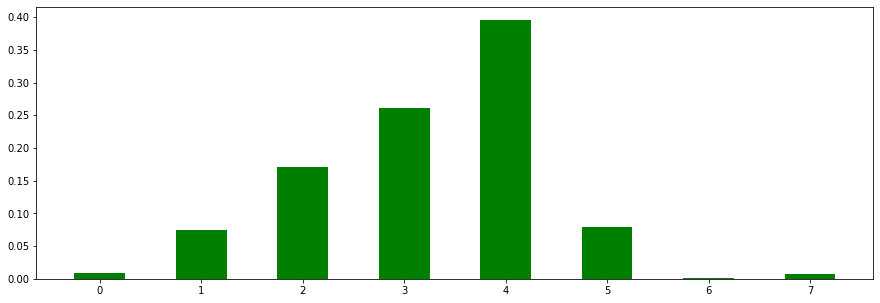

------------plots before deletion--------------
--------------plots after deletion---------------


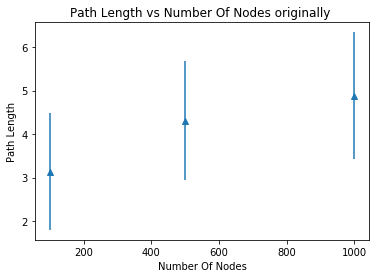

<Figure size 432x288 with 0 Axes>

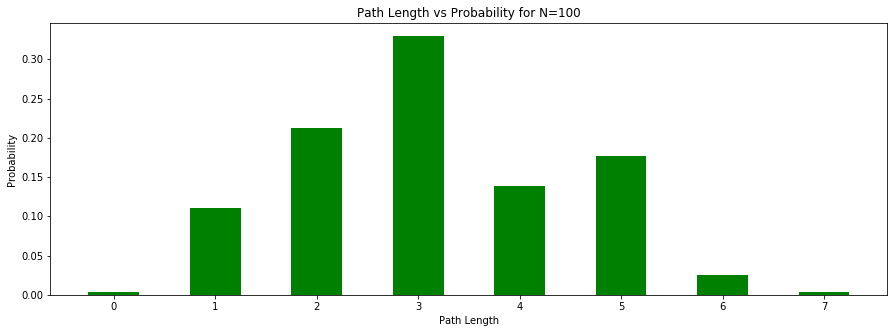

<Figure size 432x288 with 0 Axes>

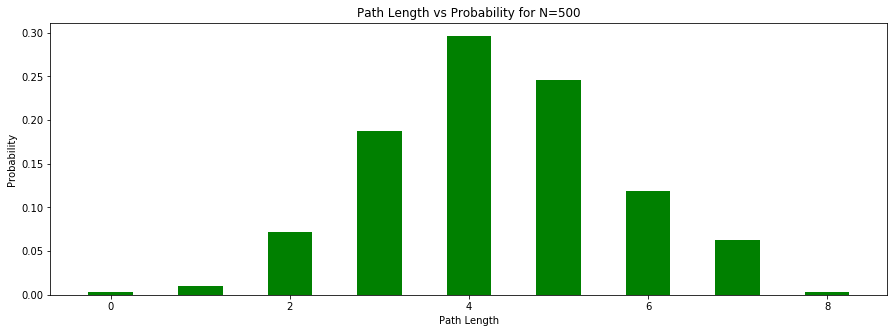

<Figure size 432x288 with 0 Axes>

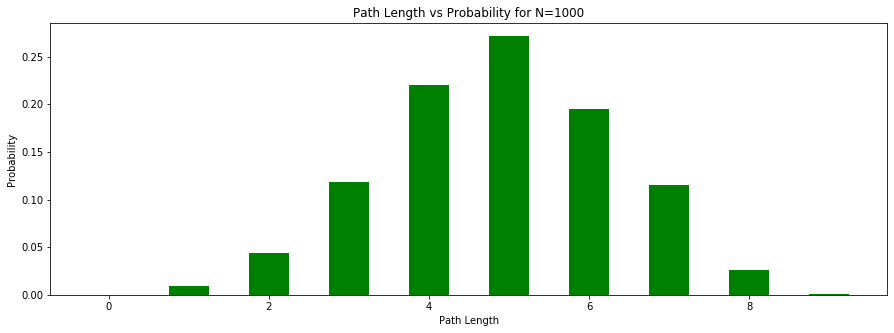

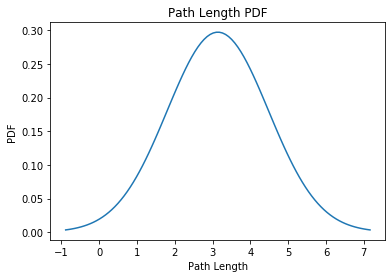

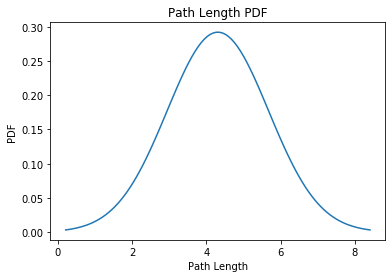

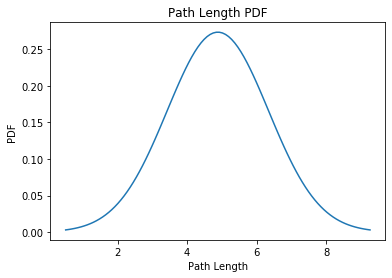

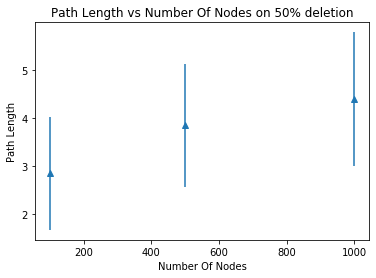

<Figure size 432x288 with 0 Axes>

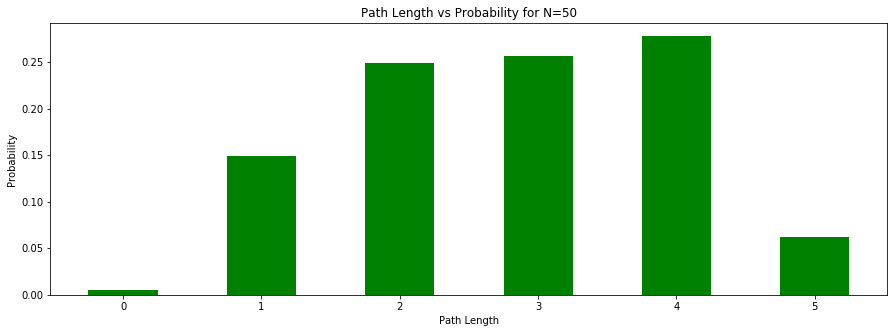

<Figure size 432x288 with 0 Axes>

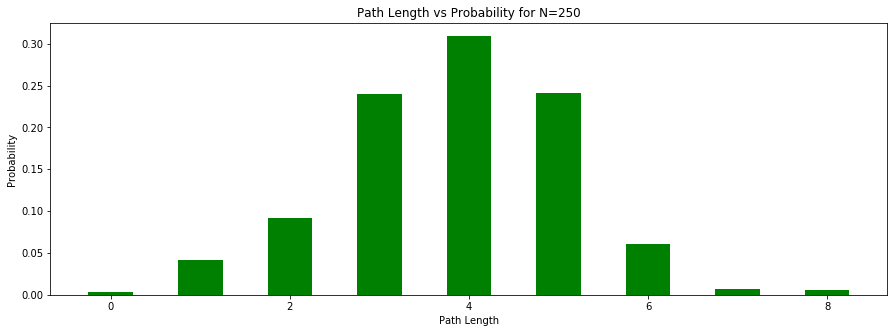

<Figure size 432x288 with 0 Axes>

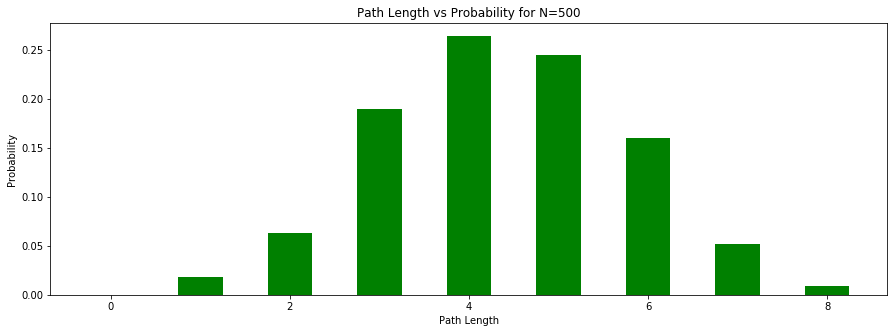

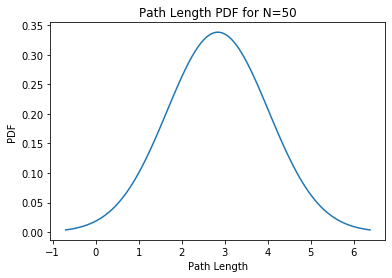

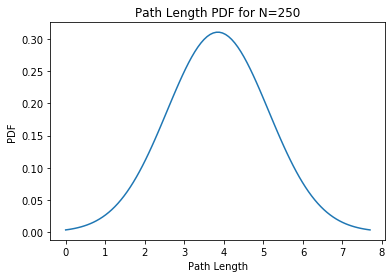

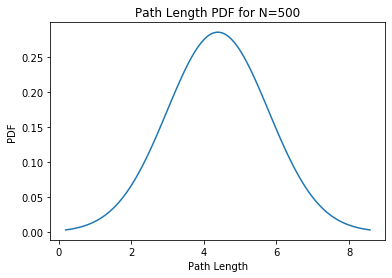

In [84]:
#----------------PLOTS-------------------
print("------------plots before deletion--------------")
mapAverageHopsMean = {}
mapAverageHopsStd = {}
mapAverageHops = {}
for key,value in totalData.items():
    
    mapAverageHops[key]=0
    count=0
    for i,j in value[0].items():
        count+=j
    listofvalues = [j for i,j in value[0].items()]
    mapAverageHopsMean[key]=np.mean(listofvalues)
    mapAverageHopsStd[key]=np.std(listofvalues)
    
lists = sorted(mapAverageHopsMean.items())
lists1 = sorted(mapAverageHopsStd.items())    
x, y = zip(*lists)
a,b = zip(*lists1)
fig1 = plt.figure()
plt.errorbar(x, y, b, linestyle='None', marker='^')
plt.xlabel("Number Of Nodes")
plt.ylabel("Path Length")
# plt.show()
plt.title("Path Length vs Number Of Nodes originally ")
plt.savefig("nodesPathLength.eps",format="eps")

numnodes = [100,500,1000]
for i in numnodes:
    fig1 = plt.figure()
    test = totalData[i][0]
    new = {}
    for k,v in test.items():
        if v not in new.keys():
            new[v]=[]
        new[v].append(k)

    new_data = {k:len(v)/numberOfSearchQueries for k,v in new.items()}
    import matplotlib.pylab as plt
    plt.figure(figsize=(15,5))
    plt.bar(new_data.keys(), new_data.values(), width=.5, color='g')
    plt.xlabel("Path Length")
    plt.ylabel("Probability")
    plt.title("Path Length vs Probability for N="+str(i))
    plt.savefig("pathLengthProbability_"+str(i)+".eps",format="eps")
    
for i in numnodes:
    out = []
    fig1 = plt.figure()
    for k,v in totalData[i][0].items():
        out.append(v)
    kde = gaussian_kde( out )
    mu = np.mean(out)
    variance = np.var(out)
    sigma = math.sqrt(variance)
    dist_space = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(dist_space, stats.norm.pdf(dist_space, mu, sigma))
    plt.xlabel("Path Length")
    plt.ylabel("PDF")
    plt.title("Path Length PDF")
    plt.savefig("pathLengthpdf_"+str(i)+".eps",format="eps")

print("--------------plots after deletion---------------")
mapAverageHopsMean = {}
mapAverageHopsStd = {}
mapAverageHops = {}
for key,value in totalDataAfterDeletion.items():
    
    mapAverageHops[key]=0
    count=0
    for i,j in value[0].items():
        count+=j
    listofvalues = [j for i,j in value[0].items()]
    mapAverageHopsMean[key]=np.mean(listofvalues)
    mapAverageHopsStd[key]=np.std(listofvalues)
    
lists = sorted(mapAverageHopsMean.items())
lists1 = sorted(mapAverageHopsStd.items())    
x, y = zip(*lists)
a,b = zip(*lists1)
fig1 = plt.figure()
plt.errorbar(x, y, b, linestyle='None', marker='^')
plt.xlabel("Number Of Nodes")
plt.ylabel("Path Length")
# plt.show()
plt.title("Path Length vs Number Of Nodes on 50% deletion")
plt.savefig("nodesPathLengthDel.eps",format="eps")

numnodes = [100,500,1000]
for i in numnodes:
    fig1 = plt.figure()
    test = totalDataAfterDeletion[i][0]
    new = {}
    for k,v in test.items():
        if v not in new.keys():
            new[v]=[]
        new[v].append(k)
    
    new_data = {k:len(v)/numberOfSearchQueries for k,v in new.items()}
    import matplotlib.pylab as plt
    plt.figure(figsize=(15,5))
    plt.bar(new_data.keys(), new_data.values(), width=.5, color='g')
    plt.xlabel("Path Length")
    plt.ylabel("Probability")
    plt.title("Path Length vs Probability for N="+str(i//2))
    plt.savefig("pathLengthProbabilityDel_"+str(i//2)+".eps",format="eps")
    
for i in numnodes:
    fig1 = plt.figure()
    out = []
    for k,v in totalDataAfterDeletion[i][0].items():
        out.append(v)
    kde = gaussian_kde( out )
    mu = np.mean(out)
    variance = np.var(out)
    sigma = math.sqrt(variance)
    dist_space = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(dist_space, stats.norm.pdf(dist_space, mu, sigma))
    plt.xlabel("Path Length")
    plt.ylabel("PDF")
    plt.title("Path Length PDF for N="+str(i//2))
    plt.savefig("pathLengthpdfdel_"+str(i//2)+".eps",format="eps")

{100: [{395935232384337555855234627247096328014029870413: 4,
   1320236459528142971276687016363815888782449508681: 4,
   663396450655934786815280055156833064516406280925: 4,
   1289302157174441725515448314821295968983905716351: 4,
   1082423872912700363479160906748630213034200087468: 4,
   997692822638677421930511268084121503145200556933: 3,
   1432162333521598174661503873789402116848380724700: 5,
   524388450923496976234765154232256536413223311975: 2,
   272921453233466284036790192944416753752492969676: 3,
   1428265955902082917154120819218952342675127941832: 5,
   244525326256248131875756581033564014754746893538: 2,
   376572409840648702011183869478948109473959929152: 4,
   374484030694720434131495594813034402093467684897: 4,
   359796274285043567909340103655291510657917266555: 3,
   1338344345010998601900625850187431982573110492497: 5,
   945739946697720996002387762431120904254542936703: 4,
   1278022573016484751809115329343574322521358283358: 4,
   629987804815859526324052664349213

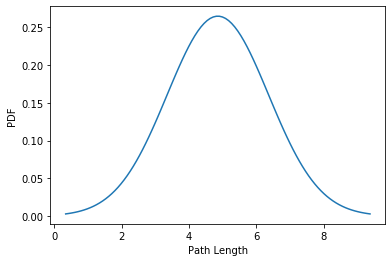